Create intermediate files for lens2.

In [1]:
import os
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from math import factorial

lensComponentDir = '../components/camera/lens2/'
intermediateDir = '../intermediateFiles/components/camera'

s1ContaminationFile = os.path.join(lensComponentDir, 'l2_Losses/l2_S1_Contamination.dat')
s2ContaminationFile = os.path.join(lensComponentDir, 'l2_Losses/l2_S2_Contamination.dat')
s1CondensationFile = os.path.join(lensComponentDir, 'l2_Losses/l2_S1_Condensation.dat')
s2CondensationFile = os.path.join(lensComponentDir, 'l2_Losses/l2_S2_Condensation.dat')
glassFile = os.path.join(lensComponentDir, 'l2_Glass.dat')
bbarS1File = os.path.join(lensComponentDir, 'l2_Coatings/l2_S1_BBAR.dat')
bbarS2File = os.path.join(lensComponentDir, 'l2_Coatings/l2_S2_BBAR.dat')
lossFile = os.path.join(intermediateDir, 'lens2/l2Losses.dat')
lensFile = os.path.join(intermediateDir, 'lens2Throughput.dat')

In [2]:
glass = np.loadtxt(glassFile)
bbarS1 = np.loadtxt(bbarS1File)
bbarS2 = np.loadtxt(bbarS2File)
s1Contamination = np.loadtxt(s1ContaminationFile)
s2Contamination = np.loadtxt(s2ContaminationFile)
s1Condensation = np.loadtxt(s1CondensationFile)
s2Condensation = np.loadtxt(s2CondensationFile)

In [3]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [4]:
smGlass = savitzky_golay(glass[:,1], 31, 3) 

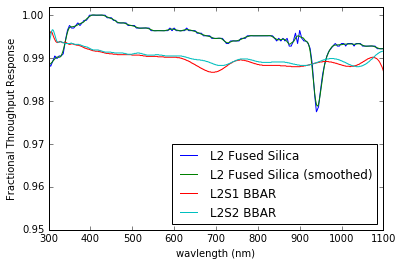

In [5]:
_ = plt.ylim([0.95, 1.002])
_ = plt.plot(glass[:,0], glass[:,1], label='L2 Fused Silica')
_ = plt.plot(glass[:,0], smGlass, label='L2 Fused Silica (smoothed)')
_ = plt.plot(bbarS1[:,0], bbarS1[:,1], label = 'L2S1 BBAR')
_ = plt.plot(bbarS2[:,0], bbarS2[:,1], label = 'L2S2 BBAR')
_ = plt.legend(loc='lower right')
_ = plt.xlabel('wavlength (nm)')
_ = plt.ylabel('Fractional Throughput Response')

In [6]:
idealLens = smGlass * bbarS1[:,1] * bbarS2[:,1]

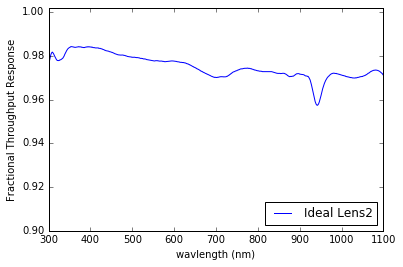

In [7]:
_ = plt.ylim([0.90, 1.002])
_ = plt.plot(glass[:,0], idealLens, label = 'Ideal Lens2')
_ = plt.legend(loc='lower right')
_ = plt.xlabel('wavlength (nm)')
_ = plt.ylabel('Fractional Throughput Response')

In [8]:
wavelen = np.arange(300, 1101, 1)
extrapolator = UnivariateSpline(s1Contamination[:,0], s1Contamination[:,1], k=1)
s1Cont = extrapolator(wavelen)
extrapolator = UnivariateSpline(s2Contamination[:,0], s2Contamination[:,1], k=1)
s2Cont = extrapolator(wavelen)
extrapolator = UnivariateSpline(s1Condensation[:,0], s1Condensation[:,1], k=1)
s1Cond = extrapolator(wavelen)
extrapolator = UnivariateSpline(s2Condensation[:,0], s2Condensation[:,1], k=1)
s2Cond = extrapolator(wavelen)

losses = s1Cont * s2Cont * s1Cond * s2Cond

np.savetxt(lossFile, zip(wavelen, losses), fmt='%.1f %.4f')

In [9]:
lensThru = idealLens * losses

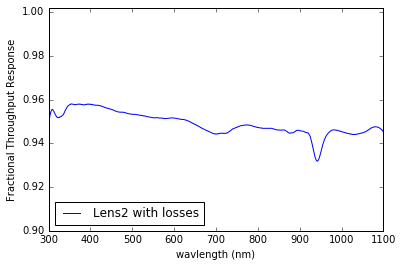

In [10]:
_ = plt.ylim([0.90, 1.002])
_ = plt.plot(wavelen, lensThru, label = 'Lens2 with losses')
_ = plt.legend(loc='lower left')
_ = plt.xlabel('wavlength (nm)')
_ = plt.ylabel('Fractional Throughput Response')

In [11]:
np.savetxt(lensFile, zip(wavelen, lensThru), fmt='%.1f %.4f')